# AMAL // Cellules à mémoire
                       notebook n°2 sur 3

On reprochait aux RNN de ne pas pouvoir comprendre les dépendances à long-terme dans des données séquentielles. Les cellules à mémoire comme celles des LSTM (Long Short-Term Memories) ou les GRU (Gated Recurrent Units) permettent de régler ce problème en conservant toutefois le même principe : une lecture de l'*input* par morceaux.

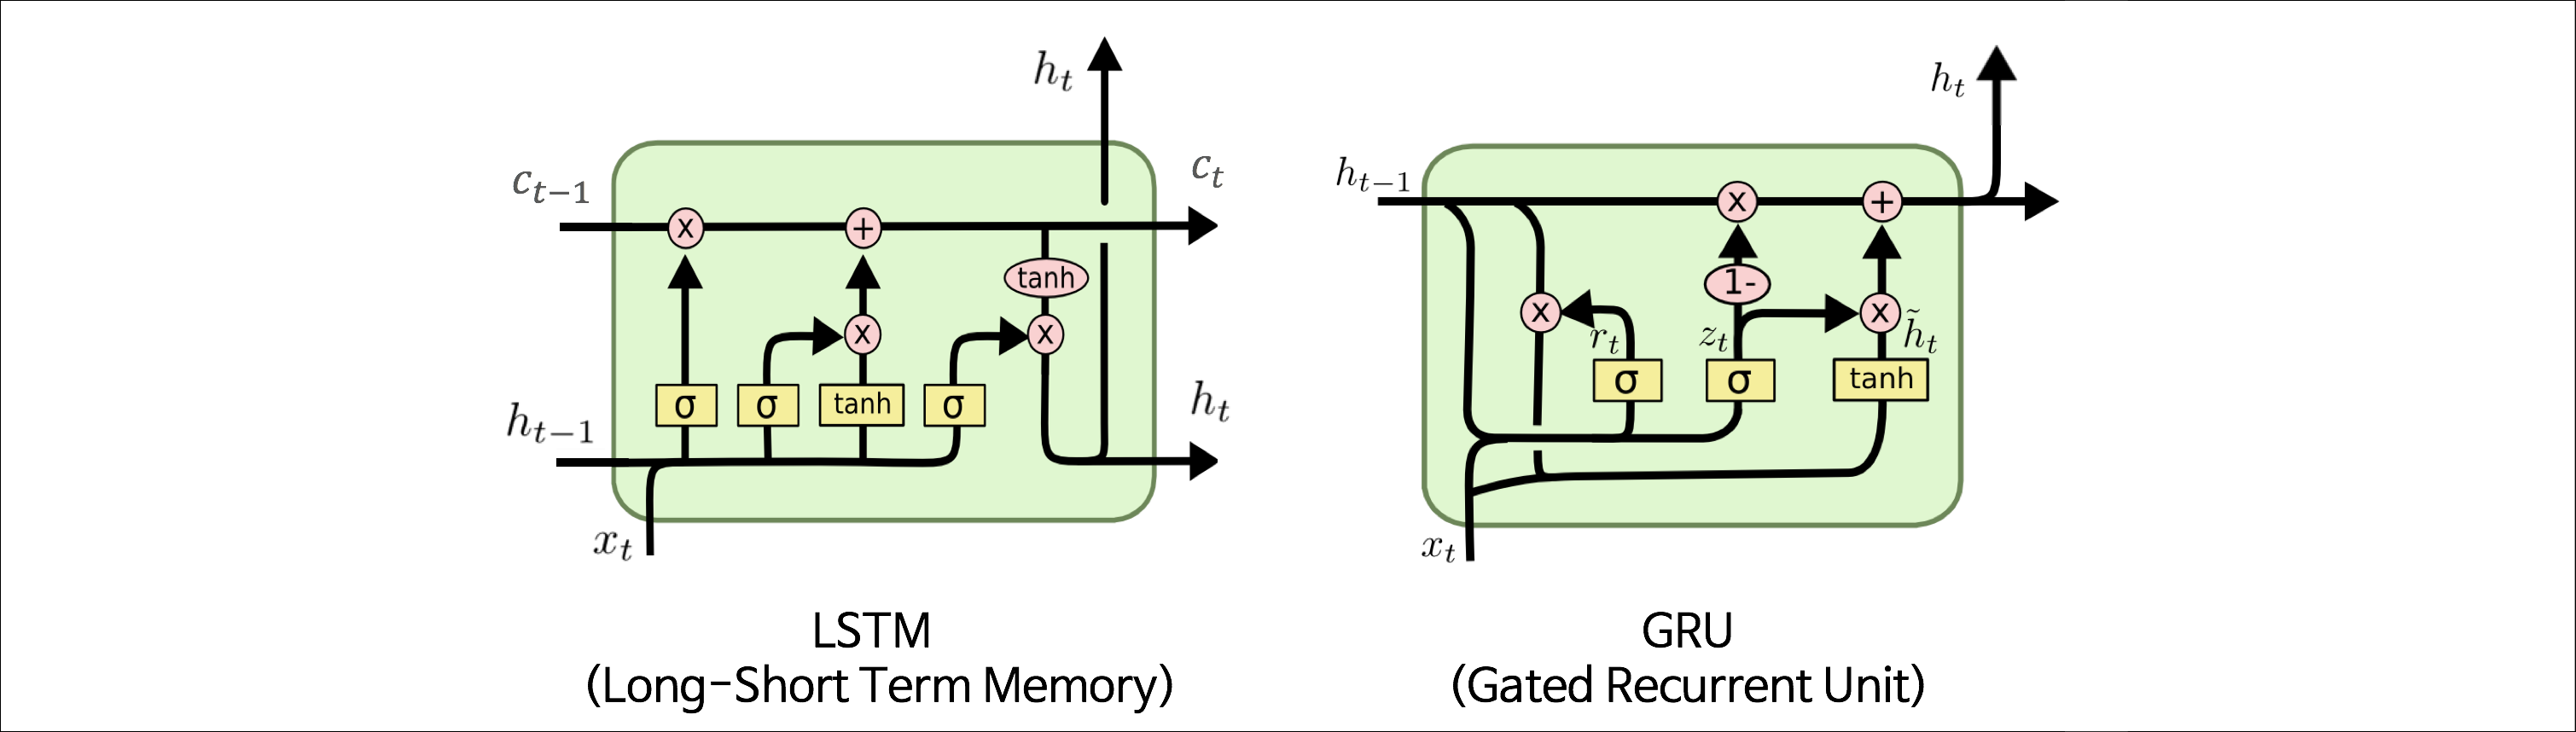


In [1]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <useful libraries> ////

# Ne pas oublier d'executer dans le shell avant de lancer python :
# source /users/Enseignants/piwowarski/venv/amal/3.7/bin/activate

import torch
from torch.utils.data import DataLoader
# On importera tous les fichiers nécessaires exercice par exercice.

# /////////////////////////////////////////////////////////////////////////////////////////////// </useful libraries> ////

In [2]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <basic configuration> ////

import logging
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO)

# /////////////////////////////////////////////////////////////////////////////////////////////// </basic configuration> ////

**DISCLAIMER : la grande quantité de résultats a rendu toutes ces expériences longues à commenter et ce rapport très long à lire.  
On a essayé de conclure en quatre lignes tout à la fin.**

### Table des matières

<a href="#data">Préparation du dataset</a>  
<a href="#trng">Préparation de l'apprentissage</a>  
<a href="#eval">Préparation des modes de génération</a>  
<a href="#grnn">Génération par RNN</a>  
&nbsp;&nbsp;Premier essai + analyse // Entraînement effectif + analyse  
<a href="#ggru">Modèles à mémoire : GRU</a>   
&nbsp;&nbsp;Entraînement GRU + analyse  
<a href="#lstm">Modèles à mémoire : LSTM</a>  
&nbsp;&nbsp;Entraînement LSTM + analyse  
<a href="#comp">Comparaison sur des phrases courtes</a>  
<a href="#tldr">TL;DR</a> 

### Préparation du dataset <a id='data'></a>

Revenons à la génération dans le style de D. Trump. Cette fois, l'objectif final est de générer des phrases entières, et donc de les finir toutes par un point (et un caractère spécifique `EndOfString`). Elles peuvent être de longueurs différentes dans le set d'entraînement.  

Le fichier `tme5trumpdataset.py` contient de quoi implémenter ce nouveau mode de fonctionnement. Il contient   
> fonction `listen` pour récupérer les chaînes de caractères du discours  
> classe `handleSpeech`pour créer le `Dataset` lié  
> fonction `collate_fn` pour assurer le padding jusqu'à la longueur maximale par batch  
> et utilitaires `normalise`, `code2string`, `string2code`

In [3]:
# /////////////////////////////////////////////////////////////////////////////////// <checking the dataset handling> ////

from tme5trumpdataset import *

test = "Greeaat. job,. honey."
loader = DataLoader(handleSpeech(test), collate_fn=collate_fn, batch_size=3)
data = next(iter(loader))
print(data)
assert data.shape == (9, 3)
assert data[2, 0] == data[3, 2]
assert test == " ".join([code2string(s).replace("|","") for s in data.t()])
print(test)
# self-esteem += 1

# ////////////////////////////////////////////////////////////////////////////////// </checking the dataset handling> ////

tensor([[34, 11,  9],
        [19, 16, 16],
        [ 6,  3, 15],
        [ 6, 65,  6],
        [ 2, 67, 26],
        [ 2,  0, 67],
        [21,  0,  0],
        [67,  0,  0],
        [ 1,  1,  1]])
Greeaat. job,. honey.


Le dataset a l'air fonctionnel.

### Préparation de l'apprentissage <a id='trng'></a>

Le fait d'avoir paddé les séquences (pour gérer les longueurs variables) doit changer le calcul des loss : on ne s'intéresse pas à ce que le modèle génère sur les positions qui contiennent un pad. On implémente donc une fonction de coût qui comporte un masque pour ignorer les caractères de padding.  
La boucle d'apprentissage est aussi transformée en fonction : le même système sera utilisé pour tous les types de modèles.

Les deux fonctions citées sont consultables dans le fichier `tme5training.py`. Il contient donc
> fonction `maskedCrossEntropy` pour assurer un calcul cohérent des loss  
> fonction `trainModel` pour lancer l'apprentissage d'un modèle récurrent (avec paramétrage + quel que soit son type)

In [4]:
from tme5training import maskedCrossEntropy,trainModel

### Modes de génération <a id='eval'></a>

Chaque modèle doit pouvoir générer des phrases nouvelles (avec ou sans prompt) après l'apprentissage.  
La fonction de génération de base ressemble à celle du TME précédent, mais comporte une condition d'arrêt différente : il faut soit générer naturellement un EOS, soit aller jusqu'à une longueur maximale s'il ne vient pas.  
On comparera la génération par *argmax* systématique à la génération par *sampling* sur les distributions prédites par les modèles.  

**On utilisera ensuite des techniques qui peuvent améliorer les résultats, comme le *beam search*.**  
Fonctionnement : après chaque pas de génération, plusieurs séquences plausibles sont gardées en mémoire. Conserver et mettre à jour séparément ces séquences de vraisemblance maximale permet de diversifier les perspectives de complétion, mais aussi d'obtenir potentiellement une phrase plus vraisemblable au final que ce qu'on obtiendrait avec l'argmax seul. Les résultats confirmeront cela.  
Nous verrons si le nucleus sampling (mise à jour limitée juste aux phrases déjà prometteuses) peut encore améliorer la situation.

Voir `tme5generation.py`, qui contient
> fonction `generate`  
> fonction `generateBeam`

In [5]:
from tme5generation import generate, generateBeam

### Génération par RNN <a id="grnn">

On récupère le modèle de `RNN` du TME4 (la façon de traiter les phrases ne change pas).  
La classe `State` va encore servir au checkpointing.

Fichier `tme5models.py`.

In [6]:
from tme5models import RNN, State

*Note* : étant données les expériences du TME4, on a augmenté le pas d'apprentissage par défaut. On a également diminué la taille de la couche d'embedding sur les conseils professoraux, il était précédemment gardé aux mêmes dimensions que le vocabulaire (`len(lettre2id)`).  
Cf. les paramètres par défaut pour l'entraînement :  
`def trainModel(modeltype,etiq,dimbed=60,latent=len(lettre2id),maxlen=200,maxiter=300,epsilon=0.001,sbatch=64)`

*Important* : à paramètres égaux (non montrés ici), l'apprentissage se fait beaucoup plus vite (facteur 10) par rapport au TME précédent, car la disparition du one-hot encoding permet de gagner beaucoup de temps.  
Cependant, c'est toujours trop. **A titre d'exemple, une longueur de séquences de 200 donnerait un temps d'entraînement de 10h sur un hardware personnel (pas encore d'accès aux GPU de l'université) ; en pratique, on bornera donc `maxlen` à 100.**  

#### PREMIER ESSAI (vérification des fonctions)

On maximise ici la rapidité de l'entraînement pour pouvoir faire quelques préobservations. On choisit donc une longueur de séquence relativement courte et on multiplie la taille des batchs (128) pour accélérer chaque epoch.

In [8]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(RNN,'RNN',maxlen=42,maxiter=300,sbatch=128)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// RNN-based generation using an embedding ///////////////////////////////

Restarting from previous state.



Trying to generate new sentences

...from known init strings (argmax)

[applause] Thank you.|
. U.|
The world read for be on a big deal.|
A lot of the story.|
We will be the story.|
$1 problems.|
That's not going to happen.|
I am and so done.|
Our country one of the built.|
Hillary Clinton was so badly.|
It's a big deal.|
The U.|
These better.|

...from empty strings (full sampling from the predicted distributions)

urats.|
ates is them in problems.|
ot of Noble got to mess.|
o well.|
ere down.|
ater Futerableat.|
ooks.|
hood.|
ow helpen.|
ooks.|

...from empty strings again (sampling the first letter + argmax)

ill and on.o want.|
o win.|
o win.|
o win.|
o win.|
o win.|
o win.|
o win.|
o win.|
o win.|


Generation with a beam search (k=7)

[applause] Thank you.|
. UR.|
The world read.|
A lot of them.|
We will Make America Safe Again.|
$1.rid.|
That's not going to happened.|
I am there have to say.|
Our much.|
Hillary.|
It's a country.|
The U.|
These going on.|


Generation with a bea

Tout semble là aussi fonctionnel.

**En général** : 


                                                                        *issu d'un run antérieur
Les prédictions ne sont pas si mauvaises.  
C'est toujours un RNN, et on travaille quand même avec des séquences longues sur lesquelles on s'attend à ce que le modèle performe mal. De fait, comme dans le TME4, il est victime de sa mauvaise mémoire : dès qu'il tombe sur un mot ou une fin de mot susceptible de terminer la phrase générée, il la coupe sans aller plus loin / sans prendre en compte le contexte et cela en fait une construction peu réaliste.

**Impact sampling vs. argmax systématique** :

Pour la génération *vanilla* (en vert, sans beam search), il y a trois groupes.  
Le premier groupe dépend d'un prompt qu'on complète avec un système d'argmax.  
Le second (exemple ci-dessous)


                                                                        
                                                                        *issu d'un run antérieur                                                        
se construit à partir de la chaîne vide et de samplings successifs lettre par lettre. En général, les phrases générées ne sont pas du tout grammaticales, car on peut tomber par hasard sur des lettres de faible probabilité qui changent le cours de la génération au milieu d'un mot. Notons quand même que le résultat a l'apparence de l'anglais - un vague air de poèmes à la Carroll.  
On a donc introduit une troisième méthode de génération (troisième groupe) où seule la première lettre est samplée, pour diversifier les générations, et la suite est construite par argmax. Cette forme mixte pourra nous aider dans nos observations. *(spoiler : elle n'a finalement pas servi à grand chose)*

**Impact du beam search** :

Le *beam search* permet effectivement de générer des séquences plus intéressantes qu'en argmax, mais au prix de calculs plus lourds (génération très lente). 

                                                                        

Toutes ne sont pas forcément plus satisfaisantes d'ailleurs.

**L'ajout du *nucleus sampling* permet d'être encore plus sévère sur la plausibilité des phrases. A priori, elles sont d'autant meilleures (= plus justes grammaticalement)** qu'il est plus restrictif. Cela a d'ailleurs tendance à favoriser la création de phrases très simples pour éviter les erreurs !  
L'autre avantage du nucleus sampling est qu'il réduit le temps de traitement en ignorant certaines possibilités.

**Analyse quantitative des résultats** : 

La courbe d'apprentissage montre que la loss descend assez bas, jusqu'à 1, 1.1. Ce n'était pas le cas dans le TME précédent (même en comparant à 100 epochs, loss=1.2 vs 1.5 précédemment). C'est probablement dû à la baisse de la dimension de sortie pour l'embedding (60) qu'on gardait précédemment à la même taille que le vocabulaire (96).

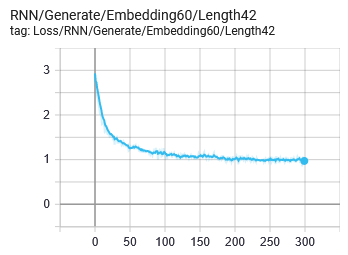

Cependant, la loss stagne et ne diminue pas davantage, même 150 itérations après la centième.

#### ENTRAÎNEMENT EFFECTIF

Cette fois, on privilégie la justesse de l'apprentissage. On fera deux fois plus de mises à jour par epoch : la taille des batchs est fixée à 64. Pour bien évaluer l'impact de la mémoire courte des RNN, les séquences d'entraînement s'allongent pour atteindre 100 caractères. Voyons comment le modèle s'en sort.

In [9]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(RNN,'RNN',maxlen=100,maxiter=300)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// RNN-based generation using an embedding ///////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] They're state the people.|
. the people.|
The world of the world.|
A lot of the world.|
We will start the people.|
$800 and the world.|
That's not the people.|
I am the world.|
Our country.|
Hillary Clinton could be a disaster.|
It's to be a disaster.|
The United States.|
These we will seen and the world.|

...from empty strings (full sampling from the predicted distributions)

ar of unbelieves better deal.|
 one of our country.|
e and was beas has into their border America we are just was look.|
 devalitaly, for are going to go 40 years very said "hans words: I the most.|
e undell Mexico of the president.|
ers.|
ars.|
e in Obaguzed of American now, they're lie.|
ory tonigratting trulity.|
er infrastring to the his flies.|

...from empty strings again (sampling the first letter + argmax)

al in the United States.|
e a country.|
e a country.|
or the world.|
 the world.|
al in the United States.|
y the peo

#### Analyse qualitative des résultats : comparaison avec la longueur 42

**En général** : Par rapport à la longueur 42, juste avec un argmax, les prédictions sont moins variées. Le modèle a l'air de se concentrer sur les mots communs utilisés par Trump. Cela dit, la présence du point empêche de se répéter à l'infini et d'avoir l'effet "disque rayé" comme au TME4.

**Impact sampling vs. argmax systématique** : Les phrases obtenues par sampling sont effectivement plus longues avec la longueur d'entraînement 100, et les mots sont plus compréhensibles, mais la sémantique n'est pas meilleure qu'auparavant.

**Impact du beam search** : Le beam search n'allonge pas du tout les phrases par rapport au run précédent : il est plus plausible que Trump prononce des phrases courtes. Par contre, elles comportent moins d'erreurs, **on a donc gagné en qualité avec ces séquences d'entraînement plus longues**.  
Le nucleus sampling n'apporte pas plus de diversité. A noter que l'on retombe sur la prédiction du beam search simple dans plusieurs cas. C'est peut-être parce que les phrases générées comme "We're going to deal" reflètent vraiment ce qui est le plus caractéristique de Trump selon le modèle.

**Analyse quantitative** :
On a perdu en termes de loss par rapport à la version maxlen=42 : elle converge plus haut, c'est le problème de la mémoire à court-terme. D'ailleurs, l'entraînement aurait pu être coupé à 200 itérations en raison de la stagnation observée autour de 1.2.

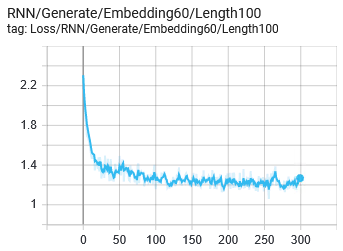

**Ce score servira de référence pour les modèles plus complexes essayés ci-dessous.**  

### Modèles à mémoire : GRU <a id="ggru">


**Entraîner les modèles pour 300 epochs prend cinq heures trente pour chacun. Cela restreint le nombre d'expériences envisageables.** Ces modèles sont plus complexes et le temps mis est normalement le prix d'une sortie plus expressive et plausible grammaticalement, y compris sur des séquences longues (100-200 caractères).

In [11]:
from tme5models import LSTM, GRU

Entre les deux, le GRU est le plus simple :

In [13]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(GRU,'GRU',maxlen=100,maxiter=300)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// GRU-based generation using an embedding ///////////////////////////////

Restarting from previous state.



Trying to generate new sentences

...from known init strings (argmax)

[applause] Thank you.|
. America again.|
The world is a lot of our country and the people of the way.|
A lot of our country and the people of the world.|
We will be a lot of our country and the people of the way.|
$5 tride deals and for the way of life starting to do it.|
That's not the people and the people of the world.|
I am going to be a lot of our country and the people of the way.|
Our country and the people of the world.|
Hillary Clinton is the streets.|
It's a lot of our country and the people of the way, so many people.|
The United States are not the people of the way, so many people.|
These are the problems in the world.|

...from empty strings (full sampling from the predicted distributions)

ets a crime and Chis choice.|
 has said in our politicians officers.|
wo, we're going to end in November.|
ers - congatilation.|
seruduaning radical Islamic for help our country.|
ing Resident Sanctuaction.|
nuphang

**Analyse qualitative :** Certaines des générations sont très satisfaisantes.



                                                                        * issu d'un run antérieur

 Le modèle produit par exemple toujours des phrases motivantes après les applaudissements.  

**Même les phrases obtenues par sampling semblent un peu plus porteuses de sens. On dirait que le GRU est plus capable de détecter des corrélations sémantiques entre les parties des phrases.  
On se débarrasse également d'un certain nombre de fautes d'accord (plus de *going to happenED*, mais peut-être est-ce un hasard).**

Cependant, les phrases obtenues par argmax seul montrent toujours des signes de répétition ("the people of the way", ce qui n'a pas de sens) ; heureusement, le beam search permet de se débarrasser de ce genre de défauts.  
Plus l'on restreint le nucleus pour le nucleus sampling, plus les phrases sont représentatives et cohérentes, même si peu élaborées. Cela reste mieux et plus diversifié que ce qu'on avait pour le RNN.

**Analyse quantitative** : même s'il s'agit des mêmes paramètres que pour le RNN, la loss se stabilise beaucoup plus bas (autour de 1/0.9).

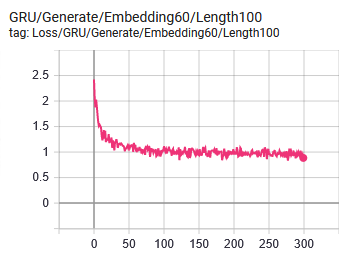

Nous constatons que ce gain en termes de loss a des effets directs sur la qualité de génération.
Par ailleurs, cette valeur de 1 est obtenue dès 50 itérations et change peu dans la suite de l'apprentissage : on a donc une convergence plutôt rapide.  

*Note : de très faibles variations dans la loss changent énormément l'output du modèle en termes de qualité. Les sorties affichées au bout de la 50ème itération sur divers essais étaient beaucoup plus basiques que celles que nous avons ici alors que la loss est à peu près la même.*

### Modèles à mémoire : LSTM <a id="lstm">

Les LSTM sont encore plus complexes que les GRU, car leurs cellules comportent en plus des états internes. Cela allonge le temps de calcul.

In [ ]:
from tme5models import LSTM

In [28]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(LSTM,'LSTM',maxlen=100,maxiter=300)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// LSTM-based generation using an embedding ///////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] We will be a company of the people and the streets.|
. is is the streets.|
The world is a great support and replaced on the people and the streets.|
A lot of the country.|
We will be a country.|
$50 percent of the United States.|
That's not the place.|
I am going to be a vote that the crime is a big times.|
Our country like they're going to be a country.|
Hillary Clinton wants to do that.|
It's the state of the country.|
The U.|
These are the streets.|

...from empty strings (full sampling from the predicted distributions)

3, they're see's congress.|
an the Senate.|
, trul it.|
 temrultry.|
wRLadyines madly A not entire starting force.|
.|
a wack a 40 Lintneating away to vote of everceder.|
 we leave every smalle-ive mean surpe.|
, it's not in.|
each protect with nong.|

...from empty strings again (sampling the first letter + argmax)

it trink the world.|
it trink the world.|
 the politicians are going



**Analyse qualitative :** les LSTM sont censées être encore meilleures pour la génération, et c'est bien le cas. Les répétitions qu'on observait pour RNN et GRU ne sont plus visibles pour les phrases produites par argmax. On a donc quelque chose de bien plus diversifié, et peu de fautes d'accord ; par contre, la sémantique des phrases n'est pas toujours optimale.

Le beam search restreint les possibilités... et met un point d'honneur à gagner l'élection : c'est en substance ce que veut dire Trump, donc ce n'est pas gênant.  
Petite note sur la génération récurrente de "The U" qui semble compromettre le reste dans le cas du nucleus sampling : ce peut être à cause du point qui suit souvent ce U dans "the U.S."

Par rapport à tout ce qui précède, les phrases obtenues avec la LSTM sont les plus complexes, même s'il y a quelques ratés.

**Analyse quantitative** : la loss ne descend pas plus bas que pour le GRU. La convergence est d'ailleurs plus lente (différence de complexité).

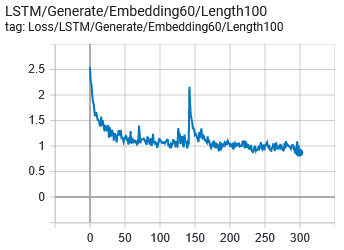

Un phénomène très important ici est le pic de loss qui apparaît au milieu de l'entraînement, et qu'il a fallu compenser. C'est potentiellement dû à l'explosion des gradients (ce qui se règle normalement par clipping). Il y a tant de paramètres dans les LSTM, il est compréhensible que leur entraînement sans mécanismes de régularisation soit aussi instable.

*Note : Il est arrivé que la loss du modèle rencontre ce genre de pic après plusieurs heures d'entraînement. Cela rendait les résultats inutilisables :*


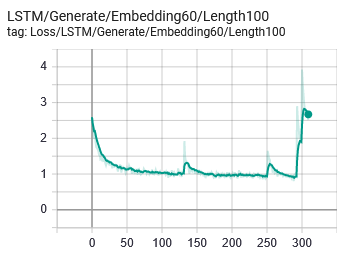

### Comparaison finale : que choisir ? <a id="comp">


Pour confirmer les observations et éviter un entraînement trop long, on a finalement relancé RNN, GRU et LSTM sur des phrases relativement courtes. 

In [25]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(RNN,'RNN',maxlen=42,maxiter=250,sbatch=64, epsilon=0.001)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// RNN-based generation using an embedding ///////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] Thank you.|
. billion in debt.|
The world Trump.|
A lot of the state.|
We will be a disaster.|
$15 too.|
That's not going to happen.|
I am not in and that was a big deal.|
Our country and more.|
Hillary Clinton lie.|
It's a great place.|
The U.|
These are the stop the stupid people.|

...from empty strings (full sampling from the predicted distributions)

o talk, today atrid.|
o great job.|
ate.|
ate.|
ate that Pay it", froty.|
ive your cander.|
e it.|
eed to duest.|
ealtys will Douthings in New Yored it was 
o is.|

...from empty strings again (sampling the first letter + argmax)

e was to do it.|
ight.|
ates.|
e was to do it.|
e was to do it.|
ight.|
ut the stop the stupid people.|
e was to do it.|
o that.|
e was to do it.|


Generation with a beam search (k=7)

[applause] Thank you.|
. billion in.|
The world Trump.|
A lot of our country.|
We will make America strong again.|
$500|
That's not going to h

In [26]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(GRU,'GRU',maxlen=42,maxiter=250,sbatch=64, epsilon=0.001)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// GRU-based generation using an embedding ///////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] Thank you.|
. Below it all ago.|
The world secure.|
A lot of the borders.|
We will make America strong again.|
$5 people.|
That's not it.|
I am so badly resunting to happen.|
Our country is not a lot of people.|
Hillary Clinton state this contrices.|
It's a disaster.|
The U.|
These are the story.|

...from empty strings (full sampling from the predicted distributions)

ort the only very isn's.|
get it.|
wall.|
 that's not going to me.|
oran's will.|
otat hat." Again.|
rangers going to win in.|
on't have no.|
timic down.|
oment The never let this.|

...from empty strings again (sampling the first letter + argmax)

mint of the money? No.bl|
" And other is a great great that.|
andidate of Clinton.|
onaly the money.|
rengly he mess.|
ust are the story.|
ention of record.|
y they're going to many ot.|
y they're going to many ot.|
here is the story.|


Generation with a beam search (k=7)

[applause] Thank you.

In [27]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

trainModel(LSTM,'LSTM',maxlen=42,maxiter=250,sbatch=64, epsilon=0.001)

# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// LSTM-based generation using an embedding ///////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] Thank you.|
. shorence three new the breach.|
The world has no change.|
A lot of them.|
We will make America safe again.|
$1 talking.|
That's not even me a litely.|
I am for Trump.|
Our country was nothing.|
Hillary Clinton say that.|
It's a disaster.|
The U.dlyand that was.|
These are the cash.on, and we're going to them.

...from empty strings (full sampling from the predicted distributions)

come on wears.|
% onaror Bill call I can about.|
estonefT, year repreign faie.|
peosted look at this.|
omen America First.|
- lass ThaDe A know.|
7 people.|
faudict guys, they are good newa by uncies
y one how to 4ate things.|
igrst anymore.|

...from empty strings again (sampling the first letter + argmax)

estory, else the way lost in socho too.|
way let this happen.|
|
ive, that was nothing.|
ive, that was nothing.|
s: I'm not going to happen.|
.|
talks.|
up as I can say that.|
talks.|


Generation with a beam 

**Analyse quantitative** : la loss du RNN est plus élevée que celle des deux autres qui finissent à peu près au même score. La convergence n'est pas terminée pour la LSTM et elle est plus lente que pour le GRU. Ce serait prometteur pour continuer l'entraînement.

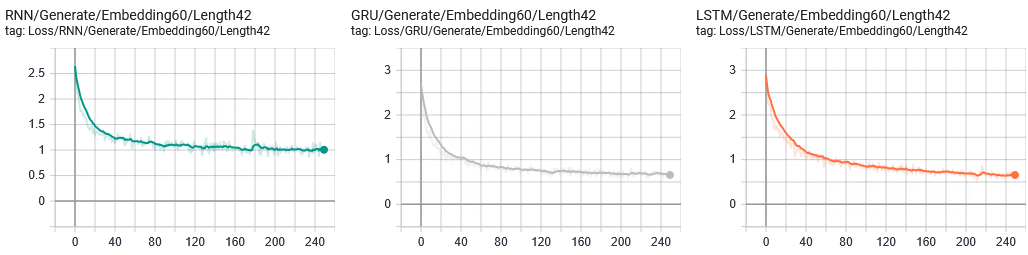

Quant à l'analyse qualitative, on la laissera à l'appréciation du lecteur.  


# Le mot de la fin <a id="tldr">

**Généralement, s'il fallait créer un avatar parlant de Trump, notre choix ne se porterait probablement pas sur un RNN mais plutôt sur un modèle à mémoire (LSTM ou GRU). Selon la complexité du discours voulu, on choisirait ensuite la fonction de génération.  
Faut-il aller au plus simple et au plus crédible ? nucleus sampling ; on aurait tendance à retrouver des phrases connues,  très vraisemblables.  
Veut-on essayer d'innover ? il faudrait peut-être entraîner le modèle plus avant, et fonctionner par argmax en espérant qu'il sera créatif.**